# Hackathon

## Importing libraries

In [63]:
import re, json

# ML Workflow
from transformers import AutoTokenizer, AutoModelForCausalLM
from diffusers import DiffusionPipeline
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

# Agentic workflow
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

# Results display
from IPython.display import display, Markdown, Image

# Agent building

## State

In [67]:
from operator import add
from typing import TypedDict, Annotated
from PIL.Image import Image as PILImage

class State(TypedDict):
  # Qwen is not multimodal, so we have to pass inputs that are not text in separate variables
  generated_model: str
  inpainting_mask: list[list[bool]]
  intermediate_image: str
  messages: Annotated[list, add]

## 3D Model generation

In [3]:
diffusion_pipeline = DiffusionPipeline.from_pretrained("segmind/tiny-sd", torch_dtype=torch.float16)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/theovld/.cache/huggingface/hub/models--segmind--tiny-sd/snapshots/cad0bd7495fa6c4bcca01b19a723dc91627fe84f/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /home/theovld/.cache/huggingface/hub/models--segmind--tiny-sd/snapshots/cad0bd7495fa6c4bcca01b19a723dc91627fe84f/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /home/theovld/.cache/huggingface/hub/models--segmind--tiny-sd/snapshots/cad0bd7495fa6c4bcca01b19a723dc91627fe84f/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /home/theovld/.cache/huggingface/hub/models--segmind--tiny-sd/snapshots/cad0bd7495fa6c4bcca01b19a723dc91627fe84f/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [17]:
def model_generation(state: State, query: str):
  # TODO: when a mask is provided, don't generate a new image but do inpainting
  # if state["inpainting_mask"] is not None:
    
  diffusion_pipeline.to(device)
  generated_image = diffusion_pipeline(query).images[0]
  diffusion_pipeline.to('cpu')
  
  generated_model = False
  return generated_image, generated_model

## Image generation

## Tools

In [62]:
# https://jdhao.github.io/2020/03/17/base64_opencv_pil_image_conversion/
import base64
from io import BytesIO
from PIL import Image as PILImage

img = PILImage.open('sample.jpg')
im_file = BytesIO()
img.save(im_file, format="JPEG")
im_bytes = im_file.getvalue()  # im_bytes: image in binary format.
im_b64 = base64.b64encode(im_bytes)

last_image = im_b64.decode('ascii')

In [60]:
import base64
from io import BytesIO

tools_doc = [
    {
        "type": "function",
        "function": {
            "name": "generate_model",
            "description": "Generate a 3D model based on the provided text prompt.",
            "parameters": {
                "type": "object",
                "properties": {
                    "query": {
                        "type": "string",
                        "description": 'The query used to generate the 3D model. It should be longer and detailed enough for best precision.',
                    },
                },
                "required": ["query"],
            },
        },
    },
]
tools = {
  "generate_model": model_generation
}

def tool_calls(state: State):
  if tool_calls := state['messages'][-1].get("tool_calls", None):
    for tool_call in tool_calls:
      fn_name: str = tool_call["name"]
      fn_args: dict = tool_call["arguments"]

      generated_model = False

      global last_image
      if last_image is None:
        (generated_image, generated_model) = json.dumps(tools[fn_name](state, **fn_args))
        
        im_file = BytesIO()
        generated_image.save(im_file, format="JPEG")
        im_bytes = im_file.getvalue()  # im_bytes: image in binary format.
        im_b64 = base64.b64encode(im_bytes)
        im_b64_str = im_b64.decode('ascii')
        
        last_image = im_b64_str
      
      return {
        'intermediate_image': last_image,
        'generated_model': generated_model,
        'messages': [
              {
              "role": "tool",
              "name": fn_name
          }
        ]
      }

def tools_node(state: State):
  # TODO: have multiple tools calling
  last_message = state['messages'][-1]
  
  match = re.search('<tool_call>\n(.+)?\n</tool_call>', last_message['content'])[1]
  try:
    func = json.loads(match)
    
    return {
      'messages': [
        {
          'role': 'assistant',
          'content': '',
          'tool_calls': [func]
        }
      ]
    }
  except json.JSONDecodeError as e:
    print(f"Failed to parse tool calls: the content is {match} and {e}")
    pass

def route_tools(state: State):
  last_message = state['messages'][-1]
  if 'tool_call' in last_message["content"]:
    return "tools"

  return END

## LLM

In [6]:
llm_model_name = "Qwen/Qwen2.5-0.5B-Instruct"

llm_tokenizer = AutoTokenizer.from_pretrained(llm_model_name)
llm_tokenizer.pad_token = llm_tokenizer.eos_token
llm_tokenizer.padding_side = "right"
llm_model = AutoModelForCausalLM.from_pretrained(llm_model_name)

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [75]:
from langgraph.types import StreamWriter
from transformers import TextIteratorStreamer
from threading import Thread 

def chatbot_node(state: State, writer: StreamWriter):
  chat = llm_tokenizer.apply_chat_template(
    state['messages'],
    tools=tools_doc,
    add_generation_prompt=True,
    tokenize=False,
    return_tensors="pt",
  )
  
  streamer = TextIteratorStreamer(llm_tokenizer, skip_prompt=True, skip_special_tokens=True)
  model_inputs = llm_tokenizer(chat, return_tensors="pt").to(device)
  llm_model.to(device)
  
  generation_args = {
      "max_new_tokens": 1024,
      "streamer": streamer,
      **model_inputs
  }
  
  # Start a separate thread for model generation to allow streaming output
  thread = Thread(
      target=llm_model.generate,
      kwargs=generation_args,
  )
  thread.start()
  
  chatbot_answer = ""
  for text_token in streamer:
      chatbot_answer += text_token
      writer({ "next_text_token": text_token })
  
  thread.join()

  return {"messages": [{'role': 'assistant', 'content': chatbot_answer }]}

## Building up the agent

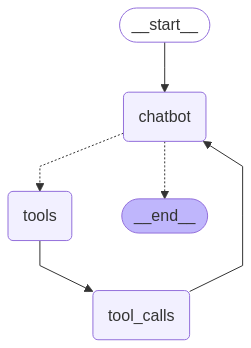

In [76]:
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot_node)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_node("tools", tools_node)
graph_builder.add_node("tool_calls", tool_calls)
graph_builder.add_conditional_edges(
  'chatbot',
  route_tools,
    {'tools': 'tools', END: END}
)
graph_builder.add_edge("tools", "tool_calls")
graph_builder.add_edge("tool_calls", "chatbot")

# agent_memory = MemorySaver()
agent_workflow = graph_builder.compile(
  # checkpointer=agent_memory
)

display(Image(agent_workflow.get_graph().draw_mermaid_png()))

# Inference

## Full conversation

In [78]:
# config = {"configurable": {"thread_id": "abc123"}}

query = "What advice can you give me to start prototyping a new airfoil?"

# TODO: integrate the system promp in the "messages" when conversing for the first time
for stream_mode, chunk in agent_workflow.stream({
    "messages": [
      {
        "role": "system",
        "content": "You are a smart assistant to help the user prototype 3D models. You are provided with a tool to do so, based on what the user wants. Don't hesitate to ask questions to precise what the user wants. Don't generate a 3D model until the user explicitly tells you to do so. Do not display the generated model in any form, only provide a concise answer of: what you did, and what you suggest next to the user."
      },
      {
        "role": "user",
        "content": query
      }
    ]
  },
  # config=config,
  stream_mode=["values", "custom"]
  ):
    if stream_mode == 'values':
      print(chunk['messages'][-1])
        
    if stream_mode == 'custom':
      print(chunk['next_text_token'], end="")

{'role': 'user', 'content': 'What advice can you give me to start prototyping a new airfoil?'}

To 
provide 
specific 
advice 
for 
starting 
the 

prototyping 
process 
for 
a 
new 


airfoil, 
I 
would 
need 
more 
details 
about 
your 
project 

goals, 
materials 

required, 
and 
any 
constraints 
or 
limitations 
you 
might 

face. 

However, 
I 
can 
offer 
some 
general 
guidance 
that 
could 
apply 
to 
many 
types 
of 
prototypes:




1. 

**Define 
Your 


Prototype**: 
Clearly 
define 
what 
you 
want 
your 
prototype 
to 
look 

like, 
including 
its 

size, 

shape, 
and 
any 
other 
characteristics 

you're 
interested 
in 



(e.g., 
surface 

finish, 
material 
type).




2. 

**Choose 

Materials**: 
Select 
appropriate 
materials 
based 
on 
the 
intended 
use 
and 
performance 
requirements 
of 
your 

prototype. 
Common 
materials 
include 
metal 

alloys, 


composites, 
and 
composite 
materials 
such 
as 
carbon 
fiber 
reinforced 
plastic 



(CFRP) 
or 
titaniu

## Interface

In [85]:
import gradio as gr

def respond(
    prompt: str,
    history,
):
    if not history:
        history = [
          {
            "role": "system",
            "content": "You are a smart assistant to help the user prototype 3D models. You are provided with a tool to do so, based on what the user wants. Don't hesitate to ask questions to precise what the user wants. Do not display the generated model in any form as it not handled by you but by another specialized application. After a generation process, provide a concise answer of: what you did, and what you suggest next to the user."
          }
        ]
    history.append({"role": "user", "content": prompt})

    yield history

    response = {"role": "assistant", "content": ""}
    for stream_mode, chunk in agent_workflow.stream(
      {
        "messages": history
      },
      stream_mode=["values", "custom"]
    ):
      if stream_mode == 'values':
        print(chunk['intermediate_image'])
        print(chunk['messages'][-1])
          
      if stream_mode == 'custom':
        response["content"] += chunk['next_text_token']

        yield history + [response]


with gr.Blocks() as demo:
    gr.Markdown("# Chat with Hugging Face Zephyr 7b 🤗")
    gr.Image()
    chatbot = gr.Chatbot(
        label="Agent",
        type="messages",
        avatar_images=(
            None,
            "https://em-content.zobj.net/source/twitter/376/hugging-face_1f917.png",
        ),
    )
    prompt = gr.Textbox(max_lines=1, label="Chat Message")
    prompt.submit(respond, [prompt, chatbot], [chatbot])
    prompt.submit(lambda: "", None, [prompt])
    
demo.launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


In [84]:
agent_workflow.get_state()

TypeError: Pregel.get_state() missing 1 required positional argument: 'config'